In [1]:
import sklearn
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_cm(y_true, y_pred,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    sns.set_style('white')
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normarlize 
    
    from sklearn.utils.multiclass import unique_labels
    classes = unique_labels(y_true, y_pred)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    pass

## Read train and test data, split by columns

In [3]:
data_test = pd.read_csv('F:\BME590-09\DS_final\Process Books\data_pp_test_30d.csv')
data_train = pd.read_csv('F:\BME590-09\DS_final\Process Books\data_pp_train_30d.csv')
#data = pd.read_csv('F:\BME590-09\DS_final\Process Books\data(with_label).csv')

In [4]:
x_test = data_test.copy()
y_test = data_test.copy()
x_train = data_train.copy()
y_train = data_train.copy()

x_test = x_test.drop(['one_year','thirty_days'],axis = 1)
x_train = y_train.drop(['one_year','thirty_days'],axis = 1)
y_test = y_test['one_year']
y_train = y_train['one_year']


In [5]:
print(x_test.shape,x_train.shape,y_test.shape,y_train.shape)

(19139, 106) (38857, 106) (19139,) (38857,)


## Set parameter vectors to compute the optimized parameters for Random Forest model.

In [6]:
param_grid = {
    #The generic form to test optimized parameter is:
    #'n_estimators' : [int(i) for i in np.linsapce(100,2000,num = 10)],
    # and below are chosen values for parameters
    'n_estimators' : [400],  
    'max_depth' : [30],
    'bootstrap': ['True'],
    'max_features' : ['auto'],
    'oob_score' : ['True'] ,
    'min_samples_leaf' : [1], 
    'min_samples_split' : [3]
}

In [7]:
clf = sklearn.ensemble.RandomForestClassifier(
    n_estimators = 2,
    bootstrap = True,
    max_depth = None
)

In [8]:
model = sklearn.model_selection.GridSearchCV(
    estimator = clf,
    param_grid = param_grid,
    n_jobs = -1,
    verbose = 3,
    scoring = 'accuracy',
    cv = 5
).fit(x_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


## Accuracy score

In [9]:
model.best_estimator_.score(x_test,y_test)

0.8847902189247087

## Plot importance of features

In [10]:
names = x_test.columns.tolist()
importance = model.best_estimator_.feature_importances_

In [11]:
dic = dict(zip(names,importance))
key_drop = [k for k in dic.keys() if  k.endswith('_mv') or k == 'icustay_age_group']
for k in key_drop:
    del dic[k]

# Remove missing value columns named with '%_mv', and remove the age_group column because it has same information with age. 
    
import operator
dic = sorted(dic.items(), key=operator.itemgetter(1))

import collections
sorted_dict = collections.OrderedDict(dic)

Text(0.5, 1.0, 'Importance of features in 30 day mortality')

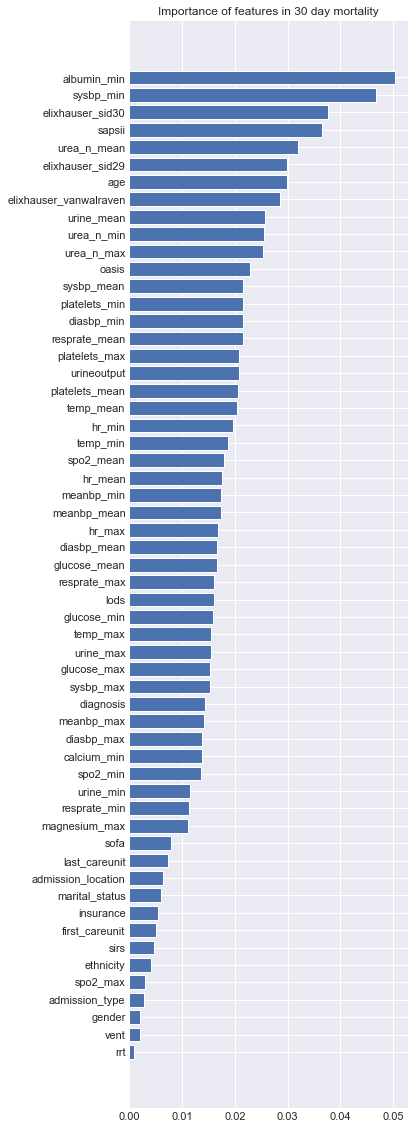

In [12]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(5,20))
ax = plt.barh(list(sorted_dict.keys()),list(sorted_dict.values()))
plt.title('Importance of features in 30 day mortality')

## Plot ROC curve

Text(0.5, 1.0, 'ROC curve for Random Forest, 30 day mortality')

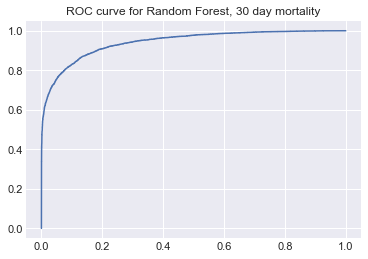

In [14]:
y_score = model.best_estimator_.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)

plt.title('ROC curve for Random Forest, 30 day mortality')


In [15]:
auc = metrics.auc(fpr, tpr)
auc

0.9423817798880512

## Confusion matrix

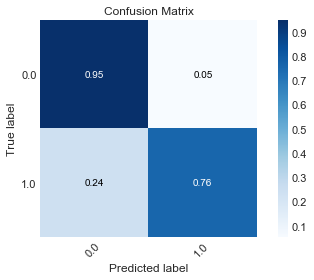

In [16]:
def probability_to_label(probabilities, threshold=0.5):
    probabilities = list(probabilities)
    th = threshold
    predictions = [1 if i > th else 0 for i in probabilities]
    return predictions

#y_score = model.best_estimator_.predict(x_test)
y_pred = probability_to_label(y_score, threshold=0.5)
plot_cm(y_test, y_pred)

## F1 Score

In [17]:
f1_score = metrics.f1_score(y_test,y_pred)
f1_score

0.8163571250104105

## PRC

In [18]:
average_precision = metrics.average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.92


In [19]:
def plot_PRC(precision, recall, ap, title= 'Precision-Recall Curve '):
    sns.set_style('whitegrid')

    plt.figure
#     plot(result5_1[0], result5_1[1],linestyle = "-", color = 'C0')#,label = 'AUC = %0.2f' % result5_1[3])
    plt.plot(recall, precision, lw=2, label='AP = %0.4f' % ap )
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")
#     plt.show()
    return 

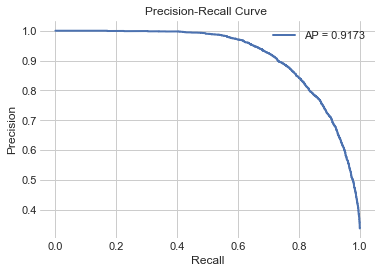

In [20]:
precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
plot_PRC(precision, recall, average_precision)

In [22]:
np.savetxt("y_score_1y_rf.csv", y_score, delimiter=",")